In [131]:
import pandas as pd

import util
import geopandas as gpd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate

import statsmodels.api as sm

In [2]:
# file paths
det_str = 'data/output/detectors_mean_3857.gpkg'
parks_str = 'data/gdf_parkingspots_clean.gpkg'

In [3]:
det = gpd.read_file(det_str, engine='pyogrio')

In [4]:
park = gpd.read_file(parks_str, engine='pyogrio')

In [5]:
det.to_crs(3857, inplace=True)
park.to_crs(3857, inplace = True)

In [6]:
park.city

0        paris, France
1        paris, France
2        paris, France
3        paris, France
4        paris, France
             ...      
55914       london, UK
55915       london, UK
55916       london, UK
55917       london, UK
55918       london, UK
Name: city, Length: 55919, dtype: object

In [7]:
park.city = park['city'].apply(lambda x: x.split(', ')[0])

In [8]:
park.city.unique()

array(['paris', 'toronto', 'melbourne', 'hamburg', 'london'], dtype=object)

In [9]:
park.head()

,city,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num,geometry
0,paris,1.0,0.0,0.0,0.0,0.0,POINT (262236.783 6253816.786)
1,paris,1.0,0.0,0.0,0.0,0.0,POINT (261978.343 6253345.552)
2,paris,1.0,0.0,0.0,0.0,0.0,POINT (261568.944 6250623.246)
3,paris,1.0,0.0,0.0,0.0,0.0,POINT (260022.482 6249808.127)
4,paris,1.0,0.0,0.0,0.0,0.0,POINT (260879.965 6249933.065)


In [10]:

det.rename(columns={'citycode': 'city'}, inplace=True)

park_g = park.groupby('city')
det_g = det.groupby('city')

In [11]:
det.head()

,detid,length,pos,fclass,road,limit,city,lanes,linkid,interval,mean_flow,std_flow,count_flow,geometry
0,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,0,62.1875,37.540711,192,POINT (1212219.462 6166949.144)
1,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,1,47.5625,36.640839,192,POINT (1212219.462 6166949.144)
2,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,2,37.5625,35.267360,192,POINT (1212219.462 6166949.144)
3,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,3,34.6875,31.057222,192,POINT (1212219.462 6166949.144)
4,U1-52G,0.196036689548578,0.005511921838942,secondary,GÃ¶gginger StraÃŸe,50,augsburg,1,72,4,39.9375,23.710211,192,POINT (1212219.462 6166949.144)


In [12]:
park.head()

,city,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num,geometry
0,paris,1.0,0.0,0.0,0.0,0.0,POINT (262236.783 6253816.786)
1,paris,1.0,0.0,0.0,0.0,0.0,POINT (261978.343 6253345.552)
2,paris,1.0,0.0,0.0,0.0,0.0,POINT (261568.944 6250623.246)
3,paris,1.0,0.0,0.0,0.0,0.0,POINT (260022.482 6249808.127)
4,paris,1.0,0.0,0.0,0.0,0.0,POINT (260879.965 6249933.065)


It is too computationally expensive to calculate all the distances dj to pi therefore we choose 100 random parking spots and look at that.

Goal is to explort the distribution of the distances and find for every city a reasonable distance. Do no run this cell light hardly.

<Axes: >

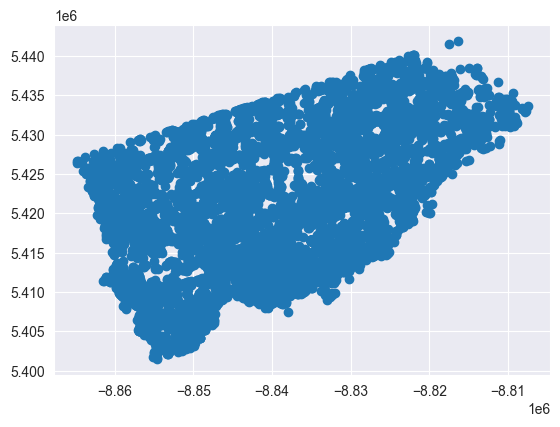

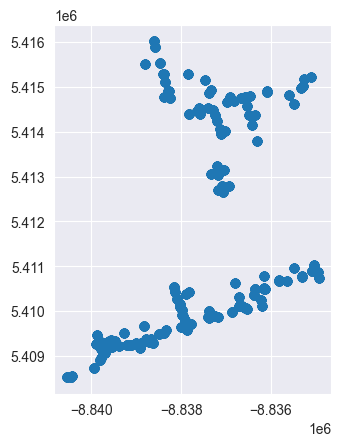

In [13]:
park_g.get_group('toronto').plot()
det_g.get_group('toronto').plot()

In [14]:
park.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
det.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
cit_dist_mean = {}
cit_dist_quant = {}
cit_dist_min = {}

for city in park['city'].unique():
    park_int = park_g.get_group(city)['geometry'].sample(1000)
    det_int = det_g.get_group(city)['geometry'].sample(200)

    #sample_p = np.random.choice(park_int,100)
    #sample_d = np.random.choice(det_int,1000)
    cit_dist_mean[city] = [np.mean([d.distance(p) for p in park_int]) for d in det_int]

    cit_dist_quant[city] = [np.quantile([d.distance(p) for p in park_int], .01) for d in det_int]

    cit_dist_min[city] = [np.min([d.distance(p) for p in park_int]) for d in det_int]

    print(city)


paris
toronto
melbourne
hamburg
london


Exploration of
* distribution of the mean distance from a detector to a parking spot
* distribution of the 1% quantil distribution from a detector to a parking spot.


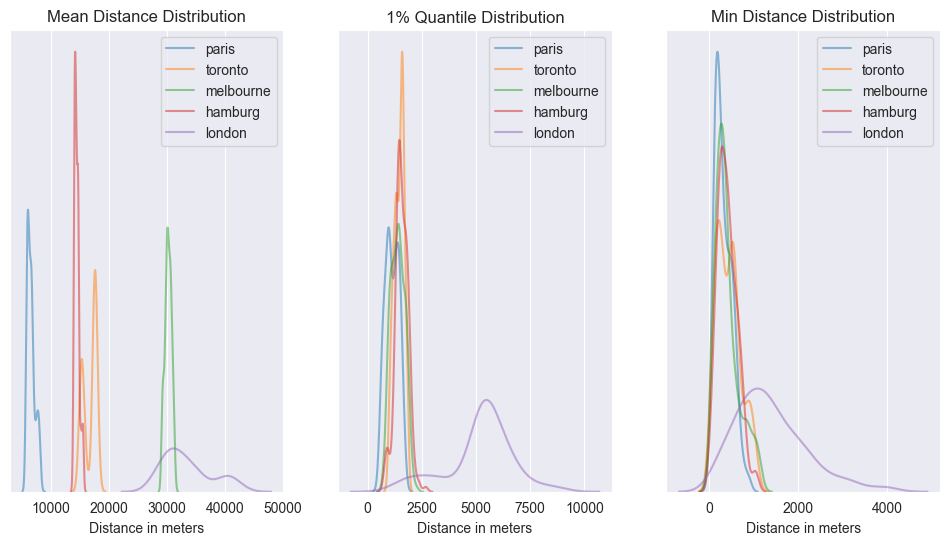

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 3, figsize=(12, 6))

for c in cit_dist_mean.keys():
    # Plot KDE
    kde_plot_mean = sns.kdeplot(cit_dist_mean[c], label=c, legend=True, ax=ax[0], alpha=.5)
    kde_plot_quant = sns.kdeplot(cit_dist_quant[c], label=c, legend=True, ax=ax[1], alpha=.5)
    kde_plot_min = sns.kdeplot(cit_dist_min[c], label=c, legend=True, ax=ax[2], alpha=.5)


    # Extract color from KDE plot
    #color_mean = kde_plot_mean.lines[-1].get_color()
    #color_quant = kde_plot_quant.lines[-1].get_color()

    # Add vertical lines to highlight the mean values with the same color as KDE plot
    #ax[0].axvline(x=np.mean(cit_dist_mean[c]), color=color_mean, linestyle='-', linewidth=2, alpha=.8)
    #ax[1].axvline(x=np.mean(cit_dist_quant[c]), color=color_quant, linestyle='-', linewidth=2, alpha=.8)
    #ax[2].axvline(x=np.mean(cit_dist_min[c]), color=color_quant, linestyle='-', linewidth=2, alpha=.8)

ax[0].legend()
ax[1].legend()
ax[2].legend()

# Remove y-axis
ax[0].yaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[2].yaxis.set_visible(False)

# Set x-axis labels and titles
ax[0].set_xlabel('Distance in meters')
ax[1].set_xlabel('Distance in meters')
ax[0].set_title('Mean Distance Distribution')
ax[1].set_title('1% Quantile Distribution')
ax[2].set_xlabel('Distance in meters')
ax[2].set_title('Min Distance Distribution')
plt.savefig('fig/distance_kde_detecs.png')
plt.show()



Interpretation:

* for all city besides london 1 of 100 detectors is connected within a distance of smaller 2000
* Therefore I would adjust the radius around a parking spot according to this threshold. The mean of the 1% distribution.

In [18]:
# Convert dictionary to list of dictionaries -> a key is regardes as a column in adf... nice to know :)
quant = [{'city': city, 'Values': values} for city, values in cit_dist_quant.items()]
min = [{'city': city, 'Values': values} for city, values in cit_dist_min.items()]
# Convert list of dictionaries to DataFrame
thres_min = pd.DataFrame(min)
thres_quant = pd.DataFrame(quant)



thres_min= thres_min.set_index('city').apply(lambda row: np.mean(row['Values']), axis=1).rename('min')
thres_quant = thres_quant.set_index('city').apply(lambda row: np.mean(row['Values']), axis=1).rename('1_g')


thres = pd.concat([thres_min, thres_quant], axis=1).unstack().reset_index().set_index('city').rename(columns={'level_0':'approach', 0: 'threshold'})

thres

,approach,threshold
city,,
paris,min,327.998440
toronto,min,443.297656
melbourne,min,410.149513
hamburg,min,413.772350
london,min,1382.596059
paris,1_g,1132.428417
toronto,1_g,1454.615435
melbourne,1_g,1398.395633
hamburg,1_g,1574.639424


<Axes: >

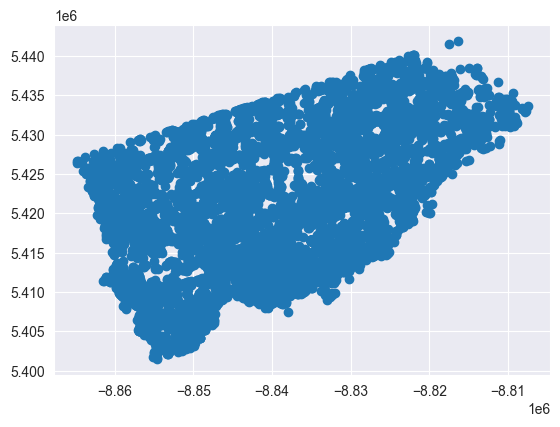

In [19]:
park[park.city=='toronto'].plot()

In [20]:
park[park.city=='toronto'].buffer(1000).head()

1386    POLYGON ((-8836098.355 5411910.767, -8836103.1...
1387    POLYGON ((-8837438.765 5411745.989, -8837443.5...
1388    POLYGON ((-8836098.278 5411581.938, -8836103.0...
1389    POLYGON ((-8836046.625 5411730.050, -8836051.4...
1390    POLYGON ((-8837952.003 5413572.494, -8837956.8...
dtype: geometry

In [21]:
det.columns

Index(['detid', 'length', 'pos', 'fclass', 'road', 'limit', 'city', 'lanes',
       'linkid', 'interval', 'mean_flow', 'std_flow', 'count_flow',
       'geometry'],
      dtype='object')

In [22]:
# Preparing the det data frame

hours_int = list(np.arange(7,19))
det_trans = det[det.interval.isin(hours_int)].groupby(['city','detid'])['mean_flow'].mean().reset_index()
det_join = det_trans.merge(det[['city','detid', 'geometry']], on =['city','detid'], how='inner').drop_duplicates(['detid', 'city'], keep= 'first')
det_joinGeo = gpd.GeoDataFrame(det_join, geometry='geometry', crs=3857)

In [23]:
det_joinGeo.groupby('city').get_group('paris').shape#208

(208, 4)

In [24]:
def spat_join(parking, detecs, thresholds):
    dfs ={}

    cities = list(parking.city.unique())

    park_vars = list(parking.columns[1:-1])

    park_g = parking.groupby('city')

    detecs_g = detecs.groupby('city')

    for c in cities:
        parking_c = park_g.get_group(c)

        detecs_c = detecs_g.get_group(c)


        thres_c = thresholds.groupby('approach').get_group('min').loc[c, 'threshold']

        detecs_int = detecs_c[['detid', 'geometry']]

        detecs_int['geometry'] = detecs_c.buffer(thres_c)

        join = detecs_int.sjoin(parking_c, how='left')

        ag = join.groupby(['detid'])[park_vars].sum().reset_index()

        dfs[c] = detecs_c.merge(ag, on=['detid'], how='inner')

    return dfs


In [25]:
df_cit = spat_join(park, det_joinGeo, thres)

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is tryin

### doing some EDA

In [26]:
# why is it alot more?
for c in df_cit.keys():
    #print(df_cit[c][df_cit[c]['detid'].duplicated()].size)
    print(df_cit[c].shape)

# where do this detecs come from?


(208, 9)
(188, 9)
(954, 9)
(418, 9)
(5719, 9)


In [27]:
det_joinGeo.groupby(['city'])['detid'].unique().apply(len)
# we see sth in the function IS FUCKED!!!

city
augsburg       713
basel           77
bern           755
birmingham      52
bolton         166
bordeaux       425
bremen         548
cagliari       122
constance      122
darmstadt      392
essen           36
frankfurt      112
graz           300
groningen       55
hamburg        418
innsbruck       16
kassel         505
london        5719
luzern         158
madrid        1116
manchester     181
marseille      169
melbourne      954
munich         520
paris          208
rotterdam      258
santander      219
speyer         184
strasbourg     142
stuttgart       34
taipeh         445
torino         388
toronto        188
toulouse       477
utrecht       1027
vilnius        581
wolfsburg      133
zurich        1020
Name: detid, dtype: int64

In [28]:
var_reg = list(park.columns[1:-1])

var_reg.append('mean_flow')

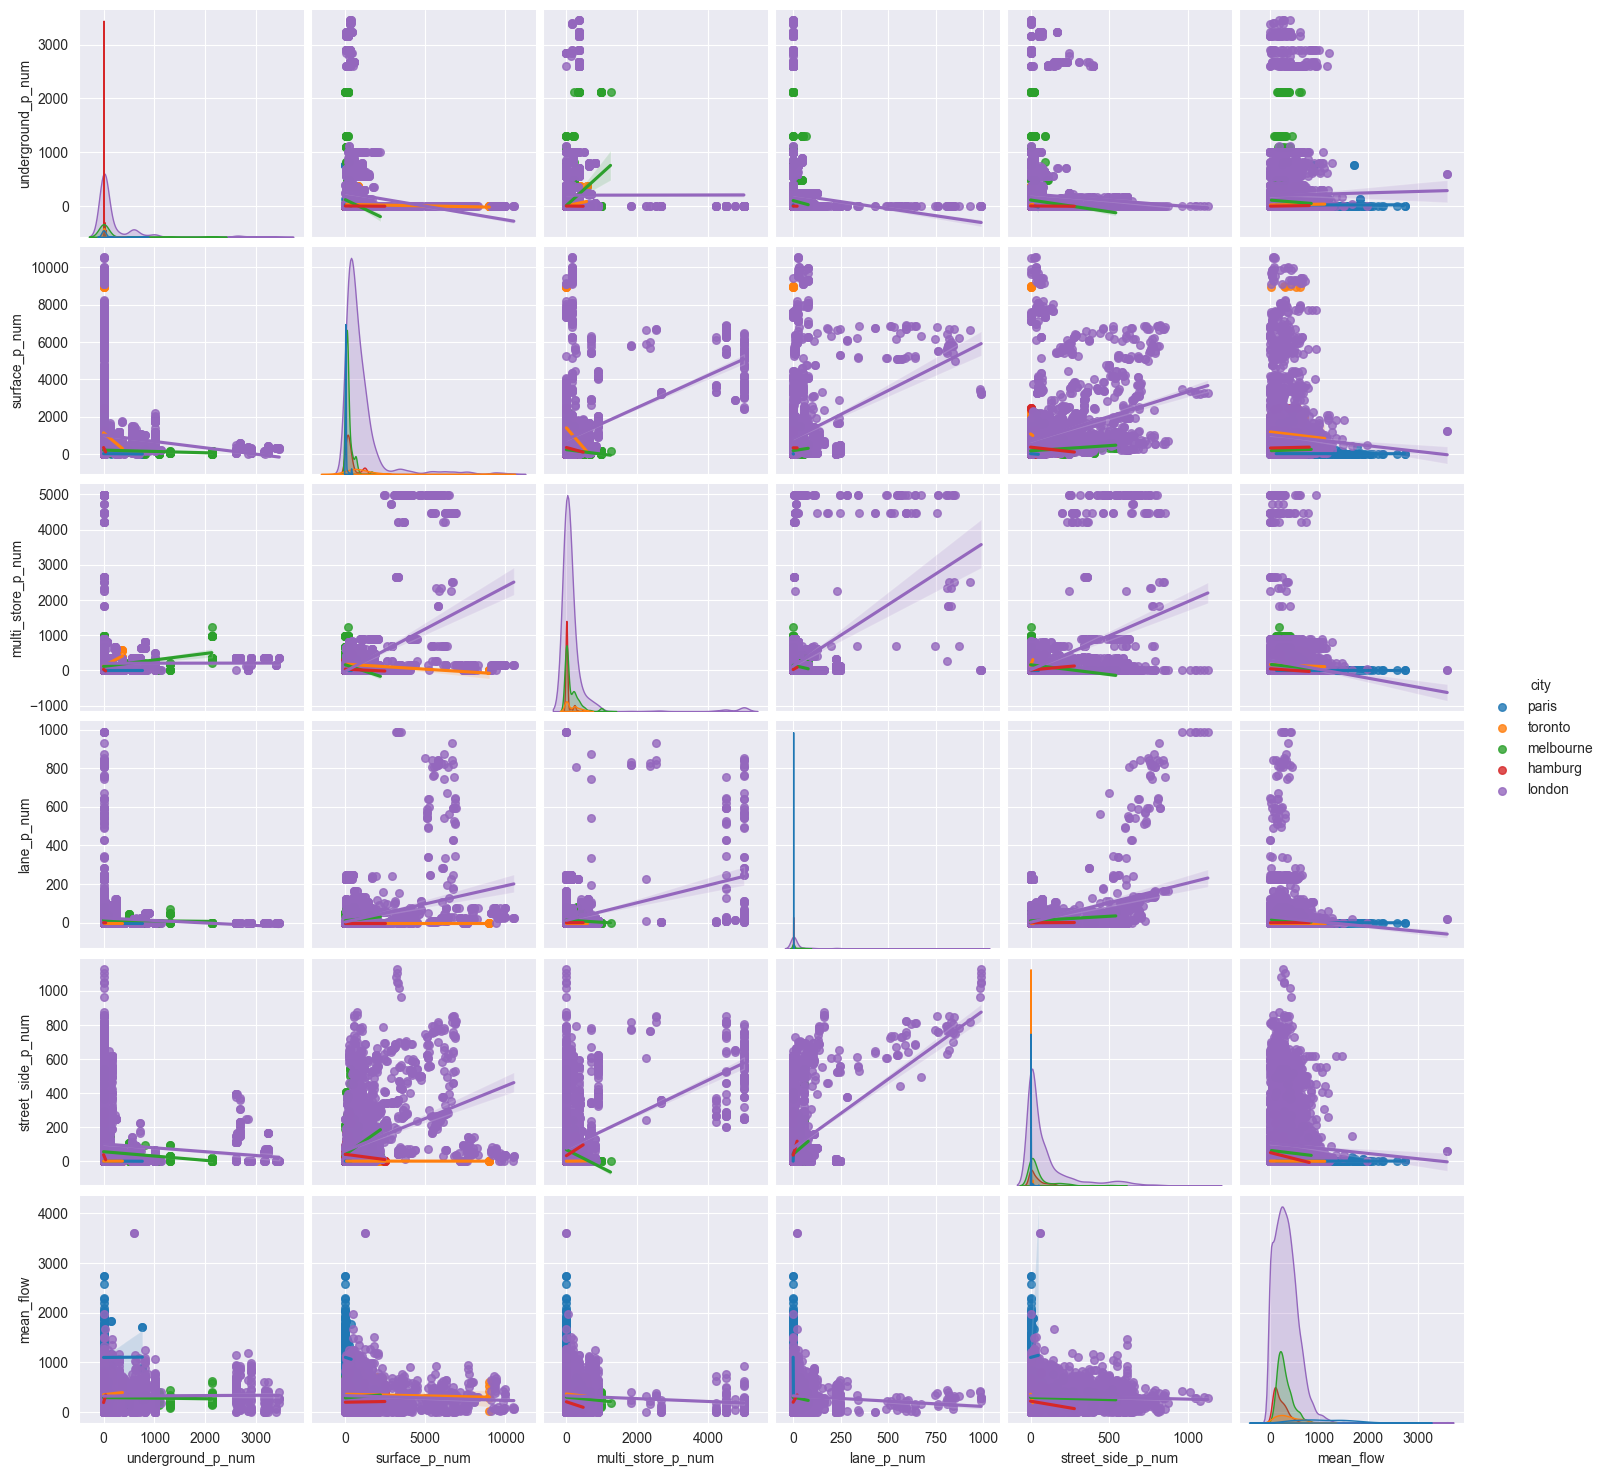

In [29]:
# Assuming df_cit, var_reg, and 'city' are defined
df_plot = pd.concat([df for df in df_cit.values()], axis=0)

# Plot the pairplot for the filtered DataFrame
sns.pairplot(df_plot, vars=var_reg, hue='city', kind='reg', plot_kws={'scatter_kws': {'s': 30}})
plt.savefig('fig\pairpl_min_assump.png')
plt.show()

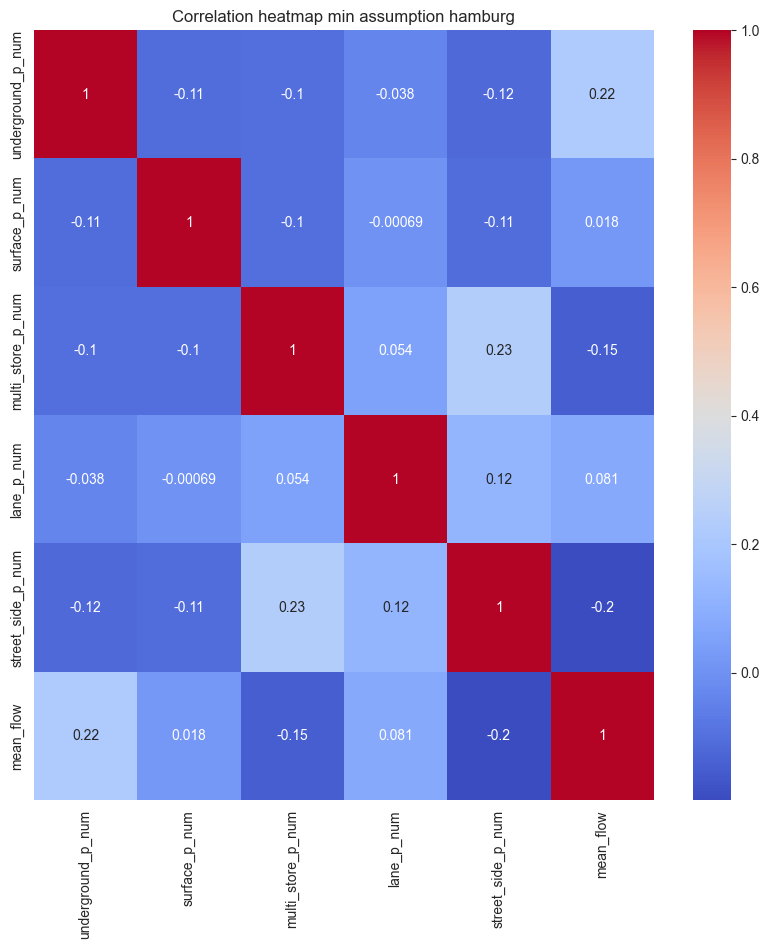

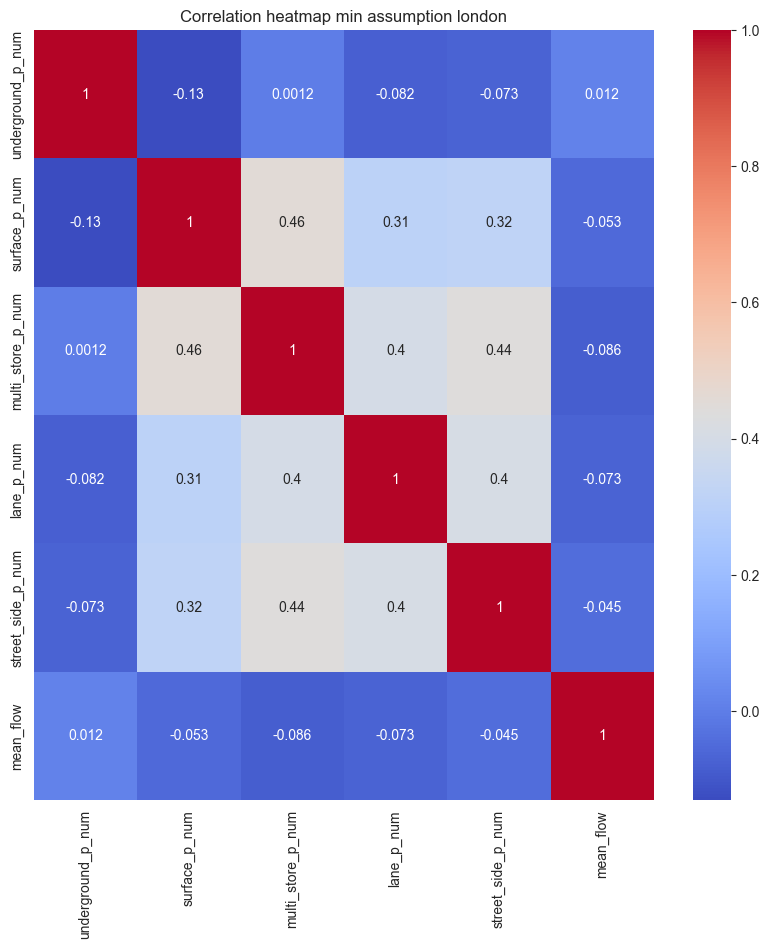

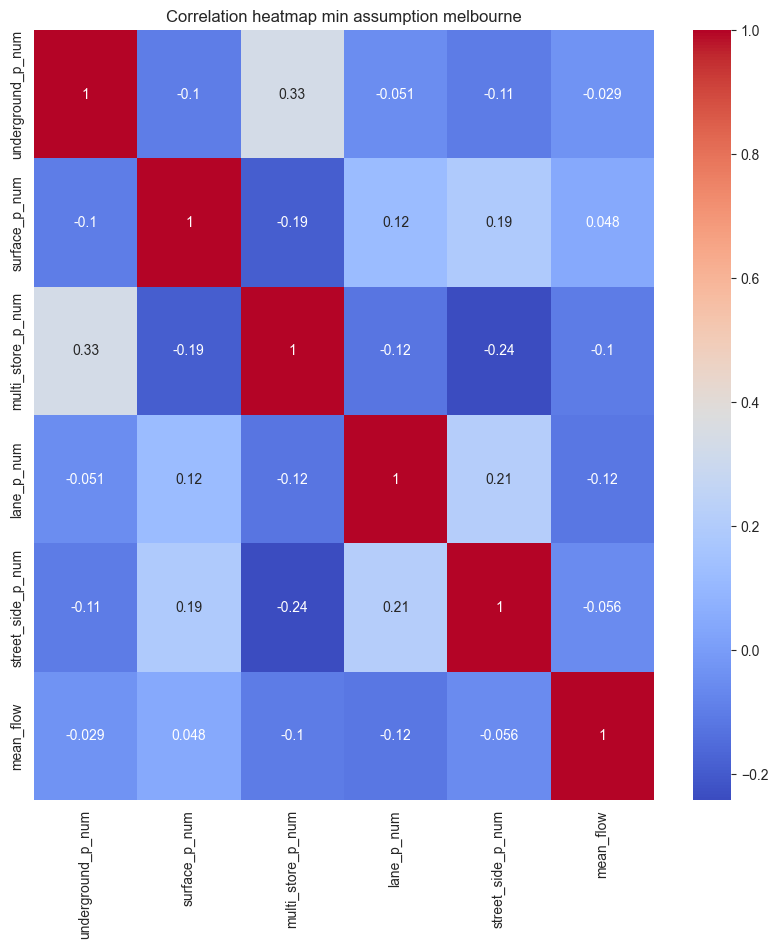

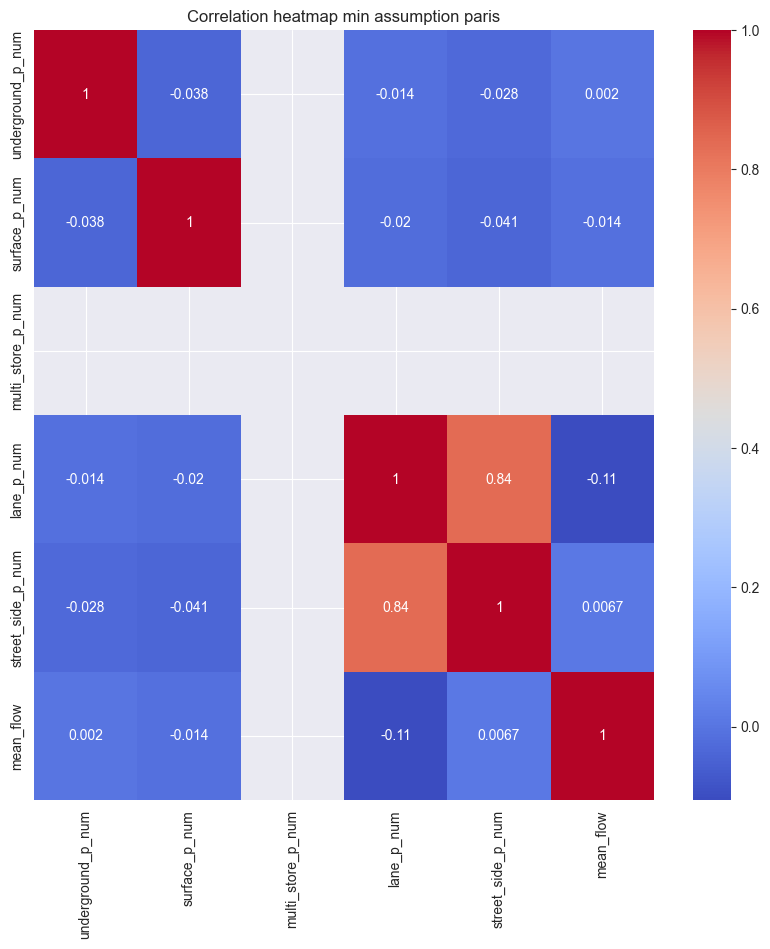

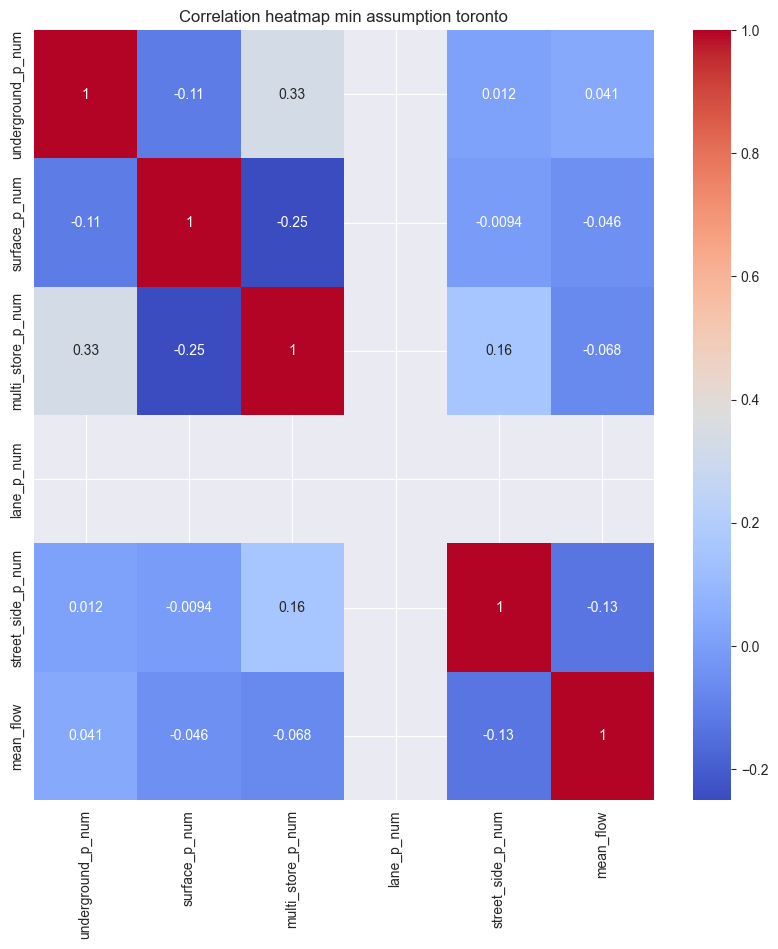

In [30]:
for c, data in df_plot.groupby('city'):
    f, ax = plt.subplots(1, figsize=(10,10))
    sns.heatmap(data[var_reg].corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation heatmap min assumption {c}')
    plt.savefig(f'fig\heat_corr_min_{c}')

#### Outlier investigation

In [31]:
var_reg

['underground_p_num',
 'surface_p_num',
 'multi_store_p_num',
 'lane_p_num',
 'street_side_p_num',
 'mean_flow']

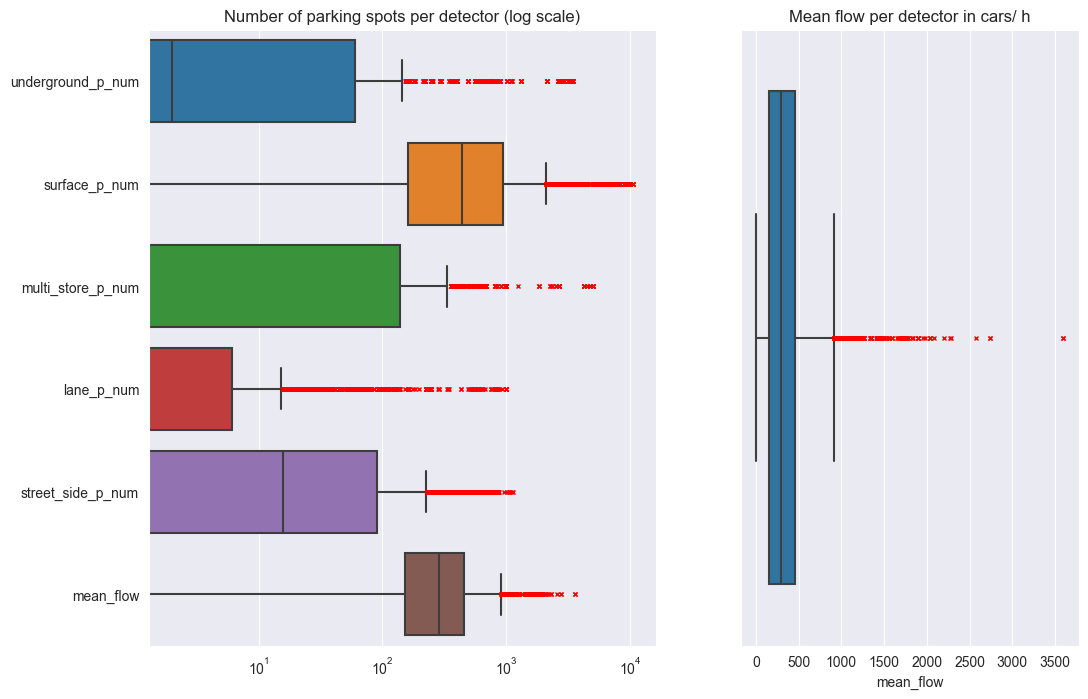

In [32]:
# Assuming df_plot and var_reg are defined
f, ax = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 2]})

sns.boxplot(data=df_plot[var_reg], orient='h', fliersize=3, flierprops={'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red'}, ax=ax[0])
ax[0].set_xscale('log')  # Set x-axis to logarithmic scale
ax[0].set_title('Number of parking spots per detector (log scale)')

sns.boxplot(data=df_plot, x='mean_flow', orient='h', fliersize=3, flierprops={'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red'}, ax=ax[1])

ax[1].set_title('Mean flow per detector in cars/ h')
plt.savefig('fig\par_det_box.png')
plt.show()


Conclusion:
* there are enormouse outliers with 3 orders of magnitude.
* Lets study the effect of this outliers.
* multi store p num and lane p num have an average value of 0  but outliers divergin by 3 orders of magnitude.

In [33]:
df_g = df_plot.groupby('city')
for c, data in df_g:
    print(f'Stats for city {c}')
    print(df_g.get_group(c).describe())

Stats for city hamburg
        mean_flow  underground_p_num  surface_p_num  multi_store_p_num   
count  418.000000         418.000000     418.000000         418.000000  \
mean   203.608963           2.414308     333.747432          29.015599   
std    131.658799           7.971171     421.732596          84.392578   
min     13.425021           0.000000       0.000000           0.000000   
25%    100.003776           0.000000      97.821981           0.000000   
50%    168.643199           0.000000     175.266263           0.000000   
75%    285.981375           0.000000     349.875154           0.000000   
max    800.385898          41.536211    2469.458812         472.811001   

       lane_p_num  street_side_p_num  
count  418.000000         418.000000  
mean     0.296245          36.423791  
std      1.527310          48.585217  
min      0.000000           0.000000  
25%      0.000000           0.000000  
50%      0.000000          21.781682  
75%      0.000000          53.671583 

We can verify:
* the number of underground_p_num is 0 on average with some very high outliers.
* in most cases the standard deviation is factor 2 higher then the mean which is tremendously high. and speaks for the falsification of our hypothesis.
* however first we should deal with the outliers. How do they behave with the traffic flow for the case of underground p num

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


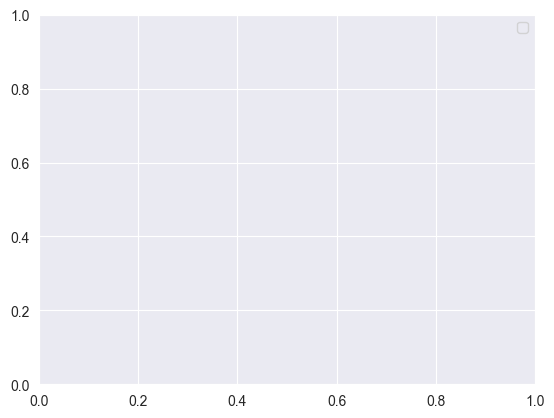

In [34]:
mask = (df_plot[var_reg] > df_plot[var_reg].quantile(0.75)).all(axis=1)
for v in var_reg:
    sns.scatterplot(df_plot[mask], x='mean_flow',y=v, label=v)
plt.legend()

* we see no significant trend in the outlier. They seem to be randomly distributed. For further analysis we drop the highest percent of values of the outliers for all the parking variables.
* the interpretation is that the outliers see also not dependent on the traffic flow

In [35]:
var_p = list(park.columns[1:-1])

In [36]:
mask = (df_plot[var_p] < df_plot[var_p].quantile(0.95)).all(axis=1)
df_reg = df_plot[mask]

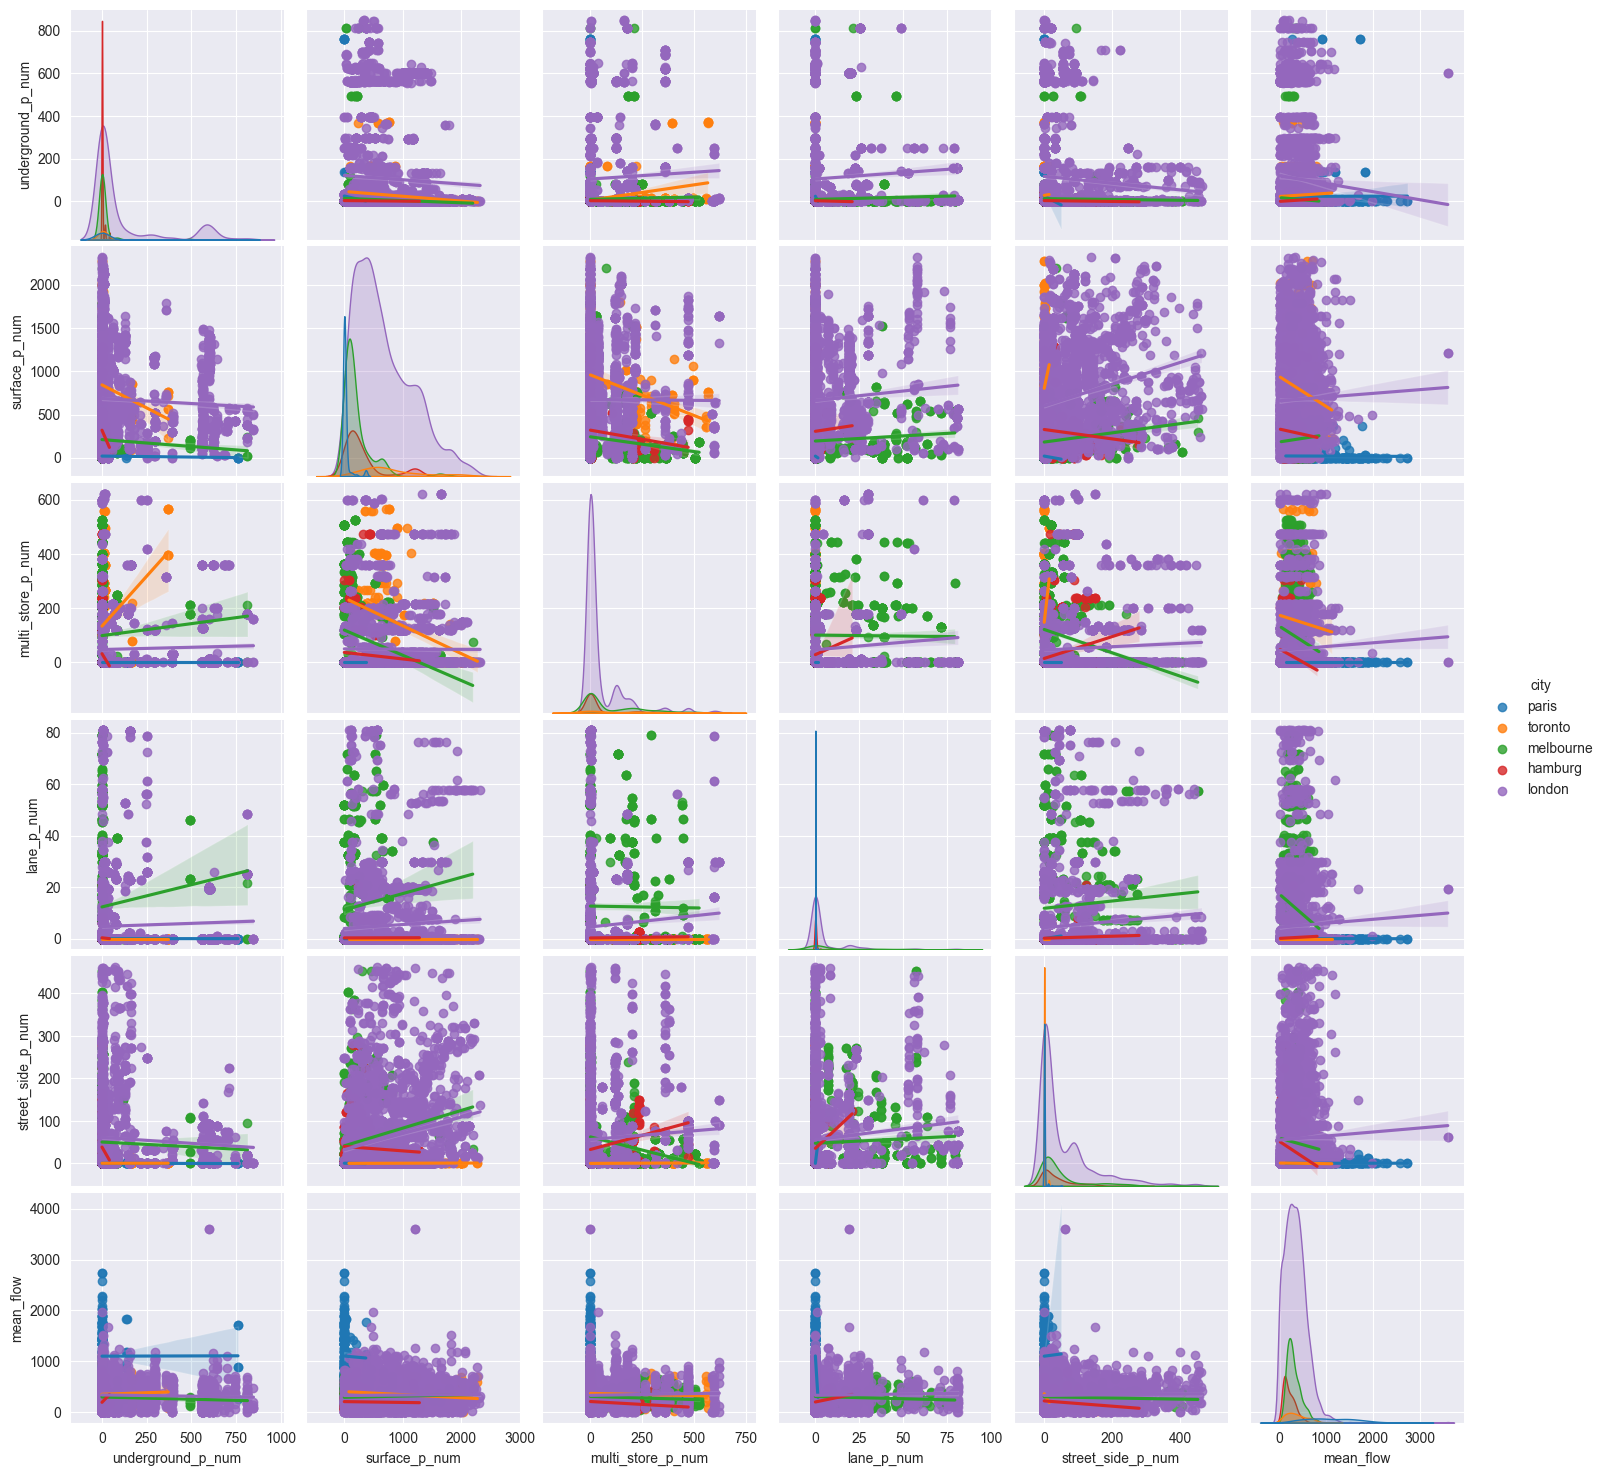

In [37]:
sns.pairplot(df_reg, vars=var_reg, hue='city', kind='reg')

* well the long tailes could be significantly reduced.
* we shold think of dropping especially lane_p_num and multi store_p_num... the values consist almost only of 0 and outliers.

#### Next we do a short study on multicollinearity.
We study this phenomena city dependent, as the corr heatmaps showed a different behaviour for the city dependent variables.

Lets first safe the file not have to start from new :


In [38]:
type(df_reg)

geopandas.geodataframe.GeoDataFrame

In [39]:
df_reg.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
df_reg.head()

,city,detid,mean_flow,geometry,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num
0,paris,1,2201.658822,POINT (259838.725 6251132.622),0.000000,0.000000,0.0,0.000000,0.000000
1,paris,10,1955.995182,POINT (261567.807 6250529.422),1.000000,0.000000,0.0,0.000000,0.000000
2,paris,1053,290.494527,POINT (256818.351 6250071.984),0.000000,0.000000,0.0,1.472007,49.753213
3,paris,11,1823.981741,POINT (261739.089 6250429.686),137.782798,36.178983,0.0,0.000000,0.000000
4,paris,1131,255.893905,POINT (259789.048 6251300.730),760.927207,0.000000,0.0,0.000000,0.000000


All there. Lets export.

In [42]:
df_reg.to_file('data/output/data_reg.gpkg', engine='pyogrio')

I use the variance inflation factor VFI to test for colinearity. It is a measure of how much the variance of the parameters of a model will increase (inflate) if a variable is added compared to the case where the variable is left out.The VIF provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

In [94]:
df_reg = gpd.read_file('data/output/data_reg.gpkg', engine='pyogrio')

In [45]:
df_reg.columns

Index(['city', 'detid', 'mean_flow', 'underground_p_num', 'surface_p_num',
       'multi_store_p_num', 'lane_p_num', 'street_side_p_num', 'geometry'],
      dtype='object')

In [ ]:
var_reg= ['multi_store_p_num', 'lane_p_num', 'street_side_p_num', 'surface_p_num', 'mean_flow']

In [55]:
def var_inf_calc(df, var):
    '''

    :param df: df with reg variables
    :param var: vars to do check for colinearity
    :return: df with index var and column city
    '''
    #if var not in df.columns:
    #    raise ValueError(f"{var} is not a column in df")

    collect ={}
    df_g = df.groupby('city')
    for c, data in df_g:
        var_inf = [variance_inflation_factor(data[var], j) for j in range(data[var].shape[1])]
        collect[c] = var_inf

    return sns.heatmap(pd.DataFrame(collect, index=var), annot=True, cmap='coolwarm')

In [50]:
var_reg

['underground_p_num',
 'surface_p_num',
 'multi_store_p_num',
 'lane_p_num',
 'street_side_p_num',
 'mean_flow']

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


<Axes: >

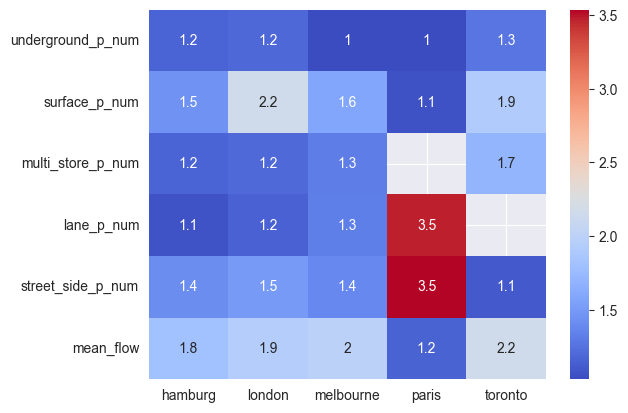

In [56]:
var_inf_calc(df_reg, var=var_reg)

Intrpretation:

* The square root of the variance inflation factor indicates how much larger the standard error increases compared to if that variable had 0 correlation to other predictor variables in the model.
* I apply the wikipedia criteria of >5 for colinearity meaning that the standard erro would be 5 times higher which is not the case for any of the vars.
* In general howver for paris we see the highest risk for colinearity between lane parking spots and street sid eparking spots.

Test for normality (gaussian) to identify if it reasonable to apply standardisation. I apply the  Shapiro-Wilk Test
Assumptions

    Observations in each sample are independent and identically distributed (iid).

Interpretation

    H0: the sample has a Gaussian distribution.
    H1: the sample does not have a Gaussian distribution


In [74]:
def normal_test (df, var):

    collect ={}
    df_g = df.groupby('city')
    for c, data in df_g:
        collect[c] =[]
        for v in var:
            collect[c] = [shapiro(data[v])[1] for v in var]


    return (pd.DataFrame(collect, index=var)>.05)

In [75]:
normal_test(df_reg,var_reg)

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,hamburg,london,melbourne,paris,toronto
underground_p_num,False,False,False,False,False
surface_p_num,False,False,False,False,False
multi_store_p_num,False,False,False,True,False
lane_p_num,False,False,False,False,True
street_side_p_num,False,False,False,False,False
mean_flow,False,False,False,False,False


Result:
* only multi_store_p_num and lane_p_num for paris and lane_p_num are probably normal distributed. -> for all the other variables the H0 is not valid anymore. -> so a standardization is not recommendable
* Because we need to normalize we apply the min max scaler. we apply it to al vars.

#### Log Transformation to deemphasize outliers and generate more normal distributions.

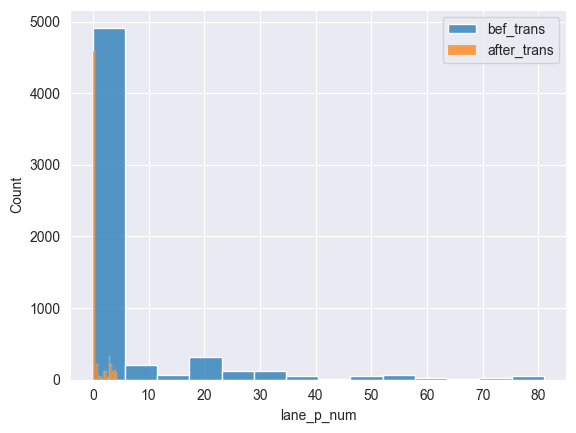

In [83]:
sns.histplot(df_reg['lane_p_num'], label='bef_trans')
sns.histplot(np.log1p(df_reg['lane_p_num']), label='after_trans')
plt.legend()

* This looks already 'better' -> the outliers are extremely deemphasized.
* I think this would be useful to apply for all the vars.

In [95]:
df_regLog = df_reg

<Axes: ylabel='Count'>

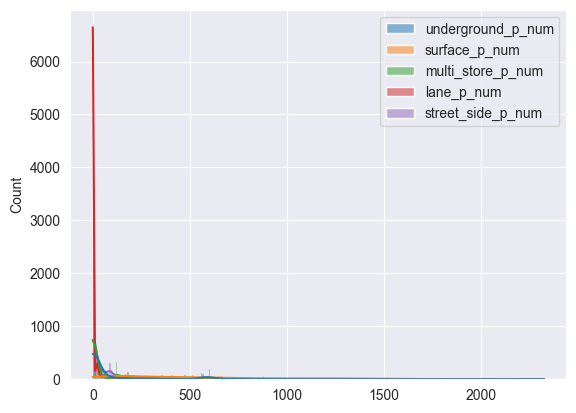

In [96]:
sns.histplot(df_reg[var_p], kde=True)

In [91]:
df_regLog[var_p] = np.log1p(df_reg[var_p])

<Axes: ylabel='Count'>

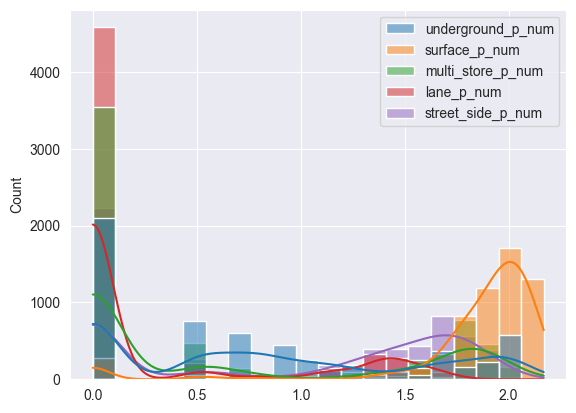

In [92]:
sns.histplot(df_regLog[var_p], kde=True)

* well whe have now a multimodal distribution.. dont know if that is a success .
Following strategy:
1. Perform a multilinear regression
2. check behaviour of residuals. -> Maybe this will help.
3. evtl check the effect of min_max scaling

#### Linear regression model

Explanation:

We do Linear multivariate regression

In [125]:
lin_mod = LinearRegression()

X= df_regLog[var_p]
y= df_regLog.mean_flow

scores = cross_validate(lin_mod, X, y,
                      scoring=('r2', 'neg_root_mean_squared_error'), return_train_score=True)

In [115]:
scores['test_neg_root_mean_squared_error'].mean() / y.mean()

-0.8111972282184122

Interpretation:
Well on aver the relative deviation of the mean is -80%

In [116]:
scores['train_neg_root_mean_squared_error'].mean() / y.mean()

-0.8007186455438294

Interpretation:
Well on aver the relative deviation of the mean is -80%

In [128]:
scores['test_r2'].mean()

-0.1311924938985089

Interpretation:

test: R2<0 means that our model is worse then the average
for the train it is slightly better but still horrible.

In [129]:
scores['train_r2'].mean()

0.01447727700356034

##### Hyothese testing

I follow [here](https://medium.com/nerd-for-tech/hypothesis-testing-on-linear-regression-c2a1799ba964)

We want to prove that there is a linear relation between the traffic flow and the parking vars. meaning that for all variables
$beta_i =_not 0$ (H1)

Therefore
$beta_i = 0$ (H0)

Lets use statsmodel bec it is bettwer for this kind of things. significants threshold >.05

In [151]:
df_regLog.head()

,city,detid,mean_flow,underground_p_num,surface_p_num,multi_store_p_num,lane_p_num,street_side_p_num,geometry
0,paris,1,2201.658822,0.000000,0.000000,0.0,0.000000,0.000000,POINT (259838.725 6251132.622)
1,paris,10,1955.995182,1.000000,0.000000,0.0,0.000000,0.000000,POINT (261567.807 6250529.422)
2,paris,1053,290.494527,0.000000,0.000000,0.0,1.472007,49.753213,POINT (256818.351 6250071.984)
3,paris,11,1823.981741,137.782798,36.178983,0.0,0.000000,0.000000,POINT (261739.089 6250429.686)
4,paris,1131,255.893905,760.927207,0.000000,0.0,0.000000,0.000000,POINT (259789.048 6251300.730)


In [160]:
df_regG = df_regLog.groupby('city')
p_coll = {}
c_coll = {}
r_coll = {}
for c, data in df_regG:
    X_g = data[var_p]
    y_g = data['mean_flow']

    X_t = sm.add_constant(X_g)
    lm = sm.OLS(y_g, X_t).fit()

    p_coll[c] = lm.pvalues

    c_coll[c] = lm.params

    r_coll[c] = lm.rsquared

    print(f'Summary statistic for {c}'+'\n\n')
    print(lm.summary())

p_values = pd.DataFrame(p_coll, index=var_p)
c_values = pd.DataFrame(c_coll, index=var_p)
r_values = pd.DataFrame(r_coll, index=var_p)


Summary statistic for hamburg


                            OLS Regression Results                            
Dep. Variable:              mean_flow   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     9.388
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           1.76e-08
Time:                        17:20:58   Log-Likelihood:                -2574.7
No. Observations:                 413   AIC:                             5161.
Df Residuals:                     407   BIC:                             5185.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const 

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


Text(0.5, 1.0, 'p_values for different cities ')

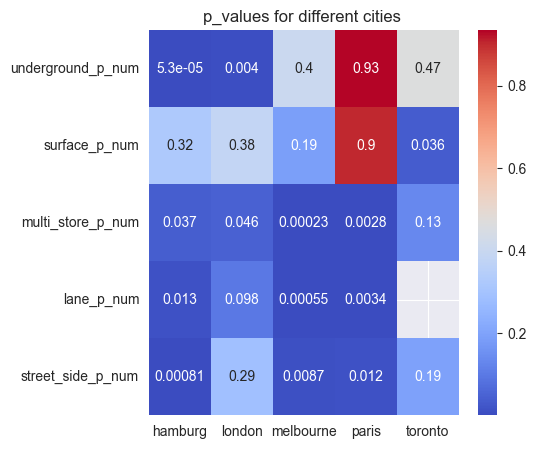

In [162]:
f, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(p_values, annot=True, cmap='coolwarm')
plt.title('p_values for different cities ')

Text(0.5, 1.0, 'Regression_coefficients for cities and parameters')

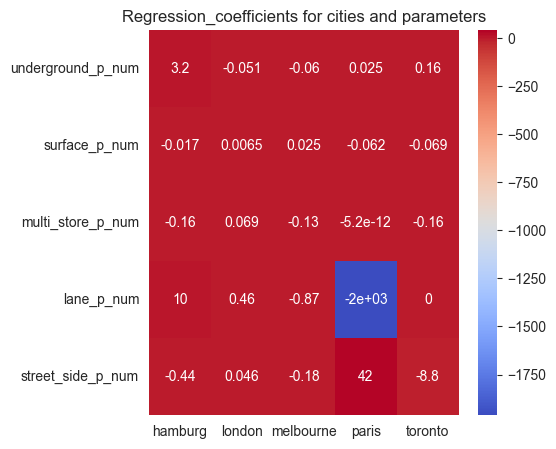

In [164]:
f, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(c_values, annot=True, cmap='coolwarm')
plt.title('Regression_coefficients for cities and parameters')

Text(0.5, 1.0, 'Regression_coefficients for cities and parameters')

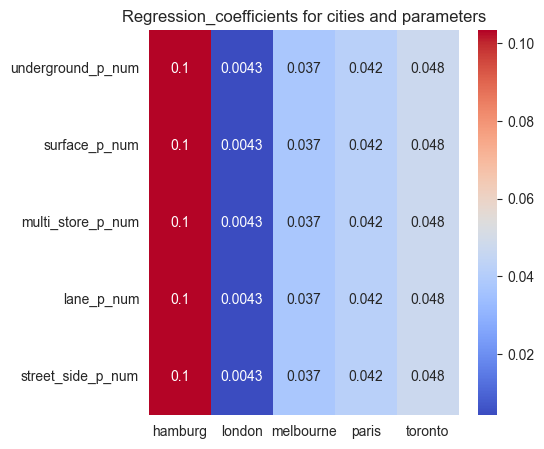

In [165]:
f, ax = plt.subplots(1, figsize=(5,5))
sns.heatmap(r_values, annot=True, cmap='coolwarm')
plt.title('Regression_coefficients for cities and parameters')

# Disucssion
* the R2 is lower (delta=.001) however considering this is only one model run  it is OK.
* the variables lane_p_num is the only value that is significant >.05 and has a negative coefficient of -4961